<a href="https://colab.research.google.com/github/donw385/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [24]:
import matplotlib

import numpy

import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=51.27167908202069, mobile=True), User(purchased=True, time_on_site=218.39905655655537, mobile=True), User(purchased=False, time_on_site=293.8837856281192, mobile=True), User(purchased=False, time_on_site=210.6664621881297, mobile=True), User(purchased=False, time_on_site=73.30358974813367, mobile=False), User(purchased=False, time_on_site=191.36109094508433, mobile=True), User(purchased=False, time_on_site=202.86335335101984, mobile=True), User(purchased=False, time_on_site=25.46984971755341, mobile=True), User(purchased=False, time_on_site=157.24103230710188, mobile=True), User(purchased=False, time_on_site=395.6857842063654, mobile=False)]


In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,51.271679,True
1,True,218.399057,True
2,False,293.883786,True
3,False,210.666462,True
4,False,73.303590,False


In [6]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.23970985040799,5.705512750941858,6.316870902692591,6.6080795023116465,7.160169977941848,7.96000458456959,9.534041392409522,9.829020078035184,10.023366924817001,10.13096640376069,...,568.3228834818145,569.3061651165532,570.2977104816991,570.8402803413865,577.4514517200215,578.0620436880133,583.3963861896933,585.6557655610828,591.8423073884194,597.1060871155424
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.648, 123.613]","(123.613, 241.986]","(241.986, 360.36]","(360.36, 478.733]","(478.733, 597.106]"
purchased,,,,,
False,269,278,162,47,45
True,70,79,39,7,4


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.648, 123.613]","(123.613, 241.986]","(241.986, 360.36]","(360.36, 478.733]","(478.733, 597.106]"
purchased,,,,,
False,0.79351,0.778711,0.80597,0.87037,0.918367
True,0.20649,0.221289,0.19403,0.12963,0.081633


In [9]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.876,0.776
True,0.124,0.224


In [13]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

a= time_bins
b = user_data['purchased']
c = user_data['mobile']


pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased              False               True           
mobile                 False     True      False     True 
time_bins                                                 
(4.648, 123.613]    0.117994  0.675516  0.026549  0.179941
(123.613, 241.986]  0.128852  0.649860  0.008403  0.212885
(241.986, 360.36]   0.203980  0.601990  0.039801  0.154229
(360.36, 478.733]   0.870370  0.000000  0.129630  0.000000
(478.733, 597.106]  0.918367  0.000000  0.081633  0.000000

In [15]:
user_data.corr()

,purchased,time_on_site,mobile
purchased,1.000000,-0.054904,0.108457
time_on_site,-0.054904,1.000000,-0.500495
mobile,0.108457,-0.500495,1.000000


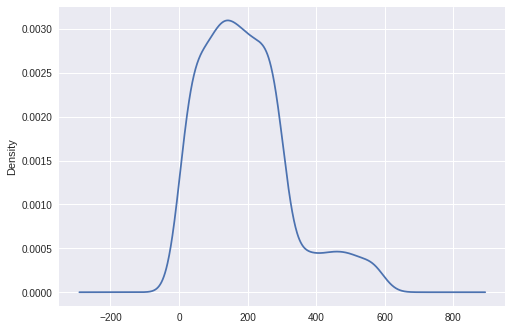

In [29]:
user_data['time_on_site'].plot.density()
plot.show()

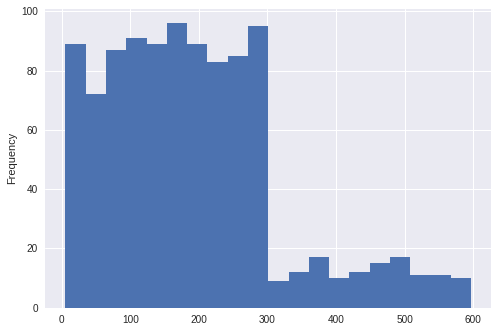

In [30]:
user_data['time_on_site'].plot.hist(bins=20)
plot.show()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)